<div style="border-top: 3px solid #0a6d91; padding: 15px; display: flex; align-items: center; justify-content: space-between;">

  <!-- Left text -->
  <div style="flex: 1; padding-right: 20px;">
    <h1 style= display: inline-block; padding: 5px 10px; border-radius: 3px;">
      Mutual Information Dynamics <br> in VAEs
    </h1>
    <h3>Information theory and inference</h3>
  </div>

  <!-- Right images -->
  <div style="flex: 0 0 auto; display: flex; align-items: center; gap: 20px;">
    <img src="https://th.bing.com/th/id/R.f158dd00f7e0e326ff081cf1acb39901?rik=tfJW%2frH3keCJ%2fg&riu=http%3a%2f%2fboostlab.dfa.unipd.it%2fimg%2flogo_pod.png&ehk=Th6GDiUuQTgD%2faBhIK7JUi15%2bG%2f35LzMJV9PFEPd9rg%3d&risl=&pid=ImgRaw&r=0" alt="PoD" width="250"/>
    <img src="https://www.unidformazione.com/wp-content/uploads/2018/04/unipd-universita-di-padova-1024x463.png" alt="UNIPD" width = "350" />
  </div>

</div>
<div style="border-bottom: 1px solid #0a6d91">
  <p><strong>Authors</strong></p>
  <table style="border-collapse: collapse; display: inline-table;">
    <tr>
      <td style="padding: 1px;">Boscolo Marco</td>
      <td style="padding: 1px;">2157559</td>
    </tr>
    <tr>
      <td style="padding: 1px;">La Rovere Francesco</td>
      <td style="padding: 1px;">2164968</td>
    </tr>
    <tr>
      <td style="padding: 1px;">Montagner Nicolò</td>
      <td style="padding: 1px;">2165809</td>
    </tr>
    <tr>
      <td style="padding: 1px;">Sabatini Raffaele</td>
      <td style="padding: 1px;">2165739</td>
    </tr>
  </table>
</div>

# 0. Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
from scipy.special import digamma
from sklearn.neighbors import NearestNeighbors

import torch
from torch import nn
#from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

# Our VAE class
from VariationalModel import *

In [3]:
# def entropy_knn(X, k=3):
#     """
#     Stima l'entropia usando k-nearest neighbors.
#     Più robusto di KDE per alta dimensione.
#     """
#     if isinstance(X, torch.Tensor):
#         X = X.detach().cpu().numpy()
    
#     if X.ndim == 1:
#         X = X.reshape(-1, 1)
    
#     n_samples, n_features = X.shape
    
#     # Trova k-nearest neighbors
#     nbrs = NearestNeighbors(n_neighbors=k+1, metric='chebyshev').fit(X)
#     distances, _ = nbrs.kneighbors(X)
    
#     # Distanza al k-esimo vicino (escludendo se stesso)
#     radius = distances[:, -1]
    
#     # Formula di Kozachenko-Leonenko
#     volume_unit_ball = np.pi ** (n_features / 2) / np.exp(digamma(n_features / 2 + 1))
    
#     H = (n_features * np.mean(np.log(radius + 1e-10)) + 
#          np.log(volume_unit_ball) + 
#          digamma(n_samples) - 
#          digamma(k))
    
#     return max(0, H)


# def mutual_info_knn(X, Y, k=3):
#     """
#     Stima I(X;Y) usando k-nearest neighbors (Kraskov estimator).
#     Questo è robusto anche per dimensioni medio-alte.
#     """
#     if isinstance(X, torch.Tensor):
#         X = X.detach().cpu().numpy()
#     if isinstance(Y, torch.Tensor):
#         Y = Y.detach().cpu().numpy()
    
#     if X.ndim == 1:
#         X = X.reshape(-1, 1)
#     if Y.ndim == 1:
#         Y = Y.reshape(-1, 1)
    
#     # Normalizza
#     X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-10)
#     Y = (Y - Y.mean(axis=0)) / (Y.std(axis=0) + 1e-10)
    
#     n_samples = X.shape[0]
    
#     # Concatena per spazio congiunto
#     XY = np.hstack([X, Y])
    
#     # Trova k-NN nello spazio congiunto
#     nbrs_joint = NearestNeighbors(n_neighbors=k+1, metric='chebyshev').fit(XY)
#     distances_joint, _ = nbrs_joint.kneighbors(XY)
#     epsilon = distances_joint[:, -1]
    
#     # Conta neighbors entro epsilon in X e Y separatamente
#     nbrs_X = NearestNeighbors(metric='chebyshev').fit(X)
#     nbrs_Y = NearestNeighbors(metric='chebyshev').fit(Y)
    
#     n_x = np.array([len(nbrs_X.radius_neighbors([x], epsilon[i])[1][0]) - 1 
#                     for i, x in enumerate(X)])
#     n_y = np.array([len(nbrs_Y.radius_neighbors([y], epsilon[i])[1][0]) - 1 
#                     for i, y in enumerate(Y)])
    
#     # Formula di Kraskov
#     mi = digamma(k) - np.mean(digamma(n_x + 1) + digamma(n_y + 1)) + digamma(n_samples)
    
#     return max(0, mi)


# # ============================================
# # 2. MI rispetto ai LABELS (come Saxe!)
# # ============================================

# def mutual_info_discrete_continuous(T, labels, bins=30):
#     """
#     Calcola I(T; Y) dove:
#     - T = attivazioni continue (N, D)
#     - labels = labels discreti (N,) con valori in {0, 1, ..., K-1}
    
#     Questo è quello che fa Saxe nel paper!
#     """
#     if isinstance(T, torch.Tensor):
#         T = T.detach().cpu().numpy()
#     if isinstance(labels, torch.Tensor):
#         labels = labels.detach().cpu().numpy()
    
#     n_samples = T.shape[0]
#     n_classes = len(np.unique(labels))
    
#     # H(Y) - entropia dei label
#     label_counts = np.bincount(labels)
#     p_y = label_counts / n_samples
#     H_Y = -np.sum(p_y * np.log2(p_y + 1e-10))
    
#     # H(Y|T) - entropia condizionale
#     # Discretizza T
#     T_discrete = np.zeros_like(T, dtype=int)
#     for d in range(T.shape[1]):
#         T_discrete[:, d] = np.digitize(T[:, d], 
#                                         np.linspace(T[:, d].min(), T[:, d].max(), bins))
    
#     # Converti ogni riga in un simbolo
#     T_symbols = [''.join(map(str, row)) for row in T_discrete]
    
#     # Calcola p(y|t) per ogni t
#     H_Y_given_T = 0
#     from collections import defaultdict
    
#     # Raggruppa per simbolo T
#     t_to_labels = defaultdict(list)
#     for t_sym, y in zip(T_symbols, labels):
#         t_to_labels[t_sym].append(y)
    
#     # Per ogni gruppo, calcola H(Y|T=t)
#     for t_sym, y_list in t_to_labels.items():
#         p_t = len(y_list) / n_samples
        
#         # Distribuzione di Y dato T=t
#         y_counts = np.bincount(y_list, minlength=n_classes)
#         p_y_given_t = y_counts / len(y_list)
        
#         # H(Y|T=t)
#         H_y_t = -np.sum(p_y_given_t * np.log2(p_y_given_t + 1e-10))
        
#         H_Y_given_T += p_t * H_y_t
    
#     # I(T;Y) = H(Y) - H(Y|T)
#     mi = H_Y - H_Y_given_T
    
#     return max(0, mi)


# # ============================================
# # 3. FUNZIONE PRINCIPALE - Versione Saxe
# # ============================================

# def VAE_info_saxe(model, dataset, device='cpu', num_samples=6000, k=3):
#     """
#     Calcola MI come nel paper di Saxe:
#     - Encoder: I(T; Y_labels) e I(T; Z)
#     - Decoder: I(T; Z) e I(T; Y_labels)
    
#     Usa k-NN per robustezza in alta dimensione.
#     """
#     model.eval()
#     model.to(device)
    
#     # Prendi campioni con labels
#     indices = np.random.choice(len(dataset), num_samples, replace=False)
    
#     X_list = []
#     Y_labels = []
    
#     for idx in indices:
#         img, label = dataset[idx]
#         X_list.append(img)
#         Y_labels.append(label)
    
#     X_batch = torch.stack(X_list).to(device)
#     Y_labels = np.array(Y_labels)
    
#     # Forward pass
#     with torch.no_grad():
#         outputs, z = model(X_batch)
    
#     # Prepara dati
#     X_data = X_batch.view(X_batch.size(0), -1).detach().cpu().numpy()
#     Z_data = activations["latent_space"].detach().cpu().numpy()
#     Y_data = activations["output_space"].detach().cpu().numpy()
    
#     mi = {"encoder": [], "decoder": []}
    
#     print("Calculating Encoder MI (using labels like Saxe)...")
#     for i in range(1, len(model.Encoder) + 1):
#         act = activations[f"encoder_layer_{i}"]
#         act = act.view(act.size(0), -1).detach().cpu().numpy()
        
#         # I(T; Y_labels) - MI rispetto alle classi
#         mi_labels = mutual_info_discrete_continuous(act, Y_labels, bins=20)
        
#         # I(T; Z) - MI rispetto allo spazio latente (KNN)
#         mi_z = mutual_info_knn(act, Z_data, k=k)
        
#         mi["encoder"].append((mi_labels, mi_z))
#         print(f"  Layer {i}: I(T;Labels)={mi_labels:.3f}, I(T;Z)={mi_z:.3f}")
    
#     print("Calculating Decoder MI...")
#     for i in range(1, len(model.Decoder) + 1):
#         act = activations[f"decoder_layer_{i}"]
#         act = act.view(act.size(0), -1).detach().cpu().numpy()
        
#         # I(T; Z)
#         mi_z = mutual_info_knn(act, Z_data, k=k)
        
#         # I(T; Y_labels) - MI rispetto alle classi (output)
#         mi_labels = mutual_info_discrete_continuous(act, Y_labels, bins=20)
        
#         mi["decoder"].append((mi_z, mi_labels))
#         print(f"  Layer {i}: I(T;Z)={mi_z:.3f}, I(T;Labels)={mi_labels:.3f}")
    
#     return mi


# # ============================================
# # 4. TRAINING MODIFICATO
# # ============================================

# def Training(model, num_epochs=10, showImage=False):
#     setup_hooks(model)
    
#     for epoch in range(num_epochs):
#         model.train()
#         losses = []
        
#         for images, _ in tqdm(trainDataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
#             images = images.to(device)
#             outputs, z = model(images)
#             targets = images.view(images.size(0), -1)
#             loss = loss_fn(outputs, targets)
            
#             optim.zero_grad()
#             loss.backward()
#             optim.step()
            
#             losses.append(loss.detach().cpu().numpy())
        
#         avg_loss = np.mean(losses)
#         train_loss_history.append(avg_loss)
        
#         # Calcola MI (ogni 2 epoche per velocità)
#         if (epoch + 1) % 2 == 0 or epoch == 0:
#             res = VAE_info_saxe(model, trainDataset, device, num_samples=5000, k=5)
#             history_encoder.append(res['encoder'])
#             history_decoder.append(res['decoder'])
        
#         print(f"TRAIN — Epoch {epoch+1}/{num_epochs} — loss: {avg_loss:.4f}")
        
#         if showImage and epoch % 5 == 0:
#             model.eval()
#             img = testDataset[0][0].unsqueeze(0).to(device)
#             with torch.no_grad():
#                 recon = model(img)[0]
            
#             fig, axs = plt.subplots(1, 2, figsize=(12, 6))
#             axs[0].imshow(img.cpu().squeeze(), cmap='gist_gray')
#             axs[0].set_title("Original")
#             axs[1].imshow(recon.cpu().squeeze().reshape(28, 28), cmap='gist_gray')
#             axs[1].set_title(f"Reconstruction (epoch {epoch+1})")
#             plt.tight_layout()
#             plt.show()
    
#     return avg_loss


# # # ============================================
# # # 5. PLOT MIGLIORATO
# # # ============================================

# # def PlotInfoPlane(mi_history_encoder, mi_history_decoder, title_suffix=""):
# #     fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
# #     epochs = len(mi_history_encoder)
# #     cmap = plt.get_cmap('plasma')
# #     colors = [cmap(i / max(1, epochs - 1)) for i in range(epochs)]
    
# #     # ENCODER
# #     ax = axes[0]
# #     n_layers = len(mi_history_encoder[0])
    
# #     for l in range(n_layers):
# #         x = [e[l][0] for e in mi_history_encoder]  # I(T; Labels)
# #         y = [e[l][1] for e in mi_history_encoder]  # I(T; Z)
        
# #         # Traccia
# #         ax.plot(x, y, 'o-', alpha=0.4, linewidth=2.5, 
# #                 label=f'Layer {l+1}', markersize=10)
        
# #         # Colora punti per epoca
# #         for ep in range(epochs):
# #             ax.scatter(x[ep], y[ep], c=[colors[ep]], 
# #                       s=100, edgecolors='black', linewidths=1, zorder=10)
    
# #     ax.set_xlabel("I(Layer; Output Labels)", fontsize=13, fontweight='bold')
# #     ax.set_ylabel("I(Layer; Latent Z)", fontsize=13, fontweight='bold')
# #     ax.set_title(f"Encoder Information Plane {title_suffix}", fontsize=15, fontweight='bold')
# #     ax.legend(loc='best', framealpha=0.9)
# #     ax.grid(True, alpha=0.3, linestyle='--')
    
# #     # DECODER
# #     ax = axes[1]
# #     n_layers = len(mi_history_decoder[0])
    
# #     for l in range(n_layers):
# #         x = [e[l][0] for e in mi_history_decoder]  # I(T; Z)
# #         y = [e[l][1] for e in mi_history_decoder]  # I(T; Labels)
        
# #         ax.plot(x, y, 'o-', alpha=0.4, linewidth=2.5,
# #                 label=f'Layer {l+1}', markersize=10)
        
# #         for ep in range(epochs):
# #             ax.scatter(x[ep], y[ep], c=[colors[ep]],
# #                       s=100, edgecolors='black', linewidths=1, zorder=10)
    
# #     ax.set_xlabel("I(Layer; Latent Z)", fontsize=13, fontweight='bold')
# #     ax.set_ylabel("I(Layer; Output Labels)", fontsize=13, fontweight='bold')
# #     ax.set_title(f"Decoder Information Plane {title_suffix}", fontsize=15, fontweight='bold')
# #     ax.legend(loc='best', framealpha=0.9)
# #     ax.grid(True, alpha=0.3, linestyle='--')
    
# #     # Colorbar
# #     sm = plt.cm.ScalarMappable(cmap=cmap, 
# #                                norm=plt.Normalize(vmin=0, vmax=epochs-1))
# #     sm.set_array([])
# #     cbar = plt.colorbar(sm, ax=axes.ravel().tolist(), 
# #                         label="Training Epoch", aspect=40)
    
# #     plt.tight_layout()
# #     plt.show()


# # ============================================
# # 6. ESECUZIONE
# # ============================================

# # # Reset histories
# # history_encoder = []
# # history_decoder = []
# # train_loss_history = []

# # # Train
# # epochs = 30
# # final_loss = Training(model, num_epochs=epochs, showImage=False)

# # # Plot
# # PlotInfoPlane(history_encoder, history_decoder)

# 1. Set up

## Tracking Layers

In [37]:
class ActivationRecorder:
    """
    Stores activations from forward hooks.

    All activations are NumPy arrays with shape:
        (num_samples, num_units)

    where:
        axis 0 -> samples
        axis 1 -> neurons / features
    """
    def __init__(self):
        self.activations = {}

    def hook(self, name):
        def _hook(module, inputs, output):
            self.activations[name] = output.detach().cpu().numpy()
        return _hook

    def register(self, model):
        self.activations.clear()

        for i, layer in enumerate(model.Encoder):
            layer.register_forward_hook(self.hook(f"encoder_layer_{i+1}"))

        for i, layer in enumerate(model.Decoder):
            layer.register_forward_hook(self.hook(f"decoder_layer_{i+1}"))

        model.LatentSpace.register_forward_hook(self.hook("latent_space"))
        model.OutputSpace.register_forward_hook(self.hook("output_space"))

    def get(self, name):
        return self.activations[name]

    def get_neuron(self, name, neuron_idx):
        """
        Returns a single neuron as shape (num_samples, 1)
        """
        return self.activations[name][:, neuron_idx:neuron_idx+1]

In [38]:
# encoder[layer][epoch] → ndarray shape (N, neurons_in_layer)
# decoder[layer][epoch] → ndarray shape (N, neurons_in_layer)
# latent[epoch]         → ndarray shape (N, latent_dim)
# output[epoch]         → ndarray shape (N, output_dim)

class MIHistory:
    def __init__(self):
        self.encoder = []
        self.decoder = []
        self.input_latent = []
        self.latent_output = []

    def append(self, mi_dict):
        self.encoder.append(mi_dict["encoder"])
        self.decoder.append(mi_dict["decoder"])
        self.input_latent.append(mi_dict["input_latent"])
        self.latent_output.append(mi_dict["latent_output"])

## Mutual Info Estimation (KDE method)

In [72]:
class KDEEstimator:
    """
    Kernel Density Estimator for entropy and mutual information.

    For data with shape (N, d):
        - N = number of samples
        - d = dimensionality (neurons)
    """
    def __init__(self, sigma):
        self.sigma = sigma
        self.last_density = None

    def density(self, data):
        N, d = data.shape

        data_sq = np.sum(data**2, axis=1, keepdims=True)
        dists_sq = data_sq + data_sq.T - 2 * data @ data.T

        sigma_scaled = self.sigma * np.sqrt(d)
        
        kernel = np.exp(-dists_sq / (2 * sigma_scaled**2))
        density = np.mean(kernel, axis=1)

        self.last_density = density
        return density

    def entropy(self, data):
        density = self.density(data)
        epsilon = 1e-10
        return -np.mean(np.log(density + epsilon))

    def mutual_information(self, X, Y):
        HX = self.entropy(X)
        HY = self.entropy(Y)
        HXY = self.entropy(np.concatenate([X, Y], axis=1))
        return HX + HY - HXY

In [73]:
def VAE_info(model, dataset, device, num_samples, sigma, RecorderActivat):
    model.eval()
    model.to(device)

    loader = torch.utils.data.DataLoader( dataset, batch_size=num_samples, shuffle=True )
    inputs, _ = next(iter(loader))
    inputs = inputs.to(device)

    with torch.no_grad():
        model(inputs)

    X = inputs.view(inputs.size(0), -1).cpu().numpy()
    Z = RecorderActivat.get("latent_space")
    Y = RecorderActivat.get("output_space")

    est = KDEEstimator(sigma)

    mi = {
        "encoder": [],
        "decoder": [],
        "input_latent": None,
        "latent_output": None
    }

    for i in range(len(model.Encoder)):
        A = RecorderActivat.get(f"encoder_layer_{i+1}")
        mi["encoder"].append((
            est.mutual_information(A, X),
            est.mutual_information(A, Z)
        ))

    for i in range(len(model.Decoder)):
        A = RecorderActivat.get(f"decoder_layer_{i+1}")
        mi["decoder"].append((
            est.mutual_information(A, Z),
            est.mutual_information(A, Y)
        ))

    mi["input_latent"] = est.mutual_information(X, Z)
    mi["latent_output"] = est.mutual_information(Z, Y)

    return mi

## Dataset

In [74]:
dataDirectory = 'Dataset'

trainDataset = torchvision.datasets.MNIST(dataDirectory, train=True, download=True)
testDataset  = torchvision.datasets.MNIST(dataDirectory, train=False, download=True)

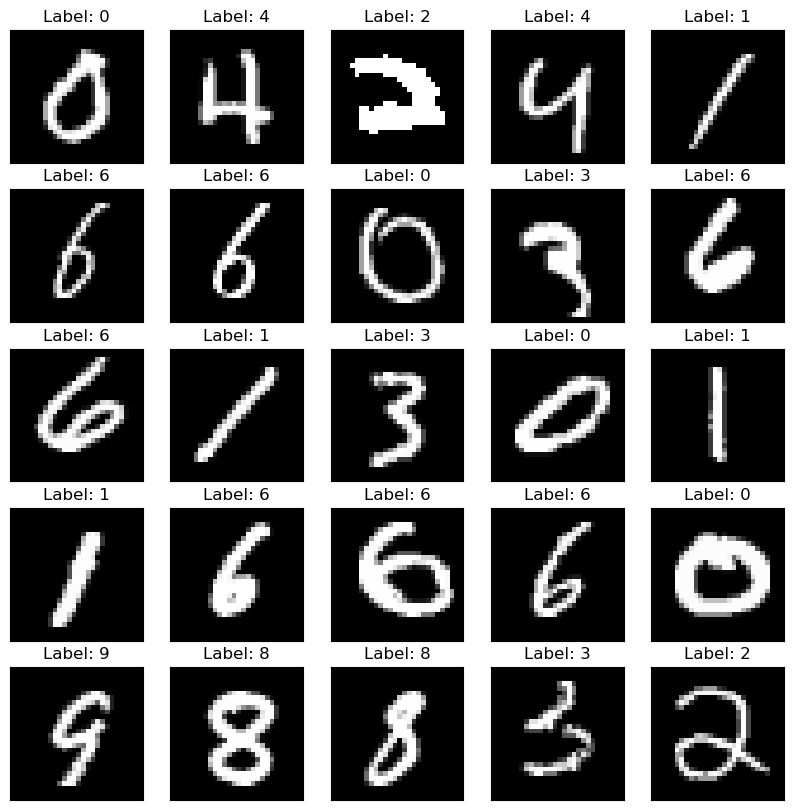

In [75]:
fig, axs = plt.subplots(5, 5, figsize = (10, 10))

for ax in axs.flatten():
   img, label = random.choice(trainDataset)
   ax.imshow(np.array(img), cmap = 'gist_gray')
   ax.set_title(f'Label: {label}')
   ax.set_xticks([])
   ax.set_yticks([])

In [76]:
#Transforms in pytorch tensors
trainTransform = transforms.Compose([transforms.ToTensor(),])
testTransform = transforms.Compose([transforms.ToTensor(),])

trainDataset.transform = trainTransform
testDataset.transform = testTransform

In [77]:
#Define the Dataloader
trainDataloader = DataLoader(trainDataset, batch_size=500, shuffle=True)
testDataloader = DataLoader(testDataset, batch_size=500, shuffle=False)

batch_data, batch_labels = next(iter(trainDataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(testDataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([500, 1, 28, 28])
	 Labels: torch.Size([500])
TEST BATCH SHAPE
	 Data: torch.Size([500, 1, 28, 28])
	 Labels: torch.Size([500])


# 2. VAE model

## Set up model

In [89]:
model = VariationalAutoEncoder(latentDim = 10, hiddenDim=[200, 150, 100, 50], Variational = True)

In [90]:
loss_fn = torch.nn.MSELoss()

lr = 5e-4
parameToOptimize = [
   {'params': model.parameters()}
]

optim = torch.optim.Adam(parameToOptimize, lr = lr)
if torch.backends.mps.is_available():
   device = torch.device("mps")
elif torch.cuda.is_available():
   device = torch.device("cuda")
else:
   device = torch.device("cpu")

print(f'Selected device: {device}')

model.to(device)

Selected device: cuda


VariationalAutoEncoder(
  (Encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=200, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=200, out_features=150, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=150, out_features=100, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=100, out_features=50, bias=True)
      (1): ReLU()
    )
  )
  (LatentLayerMu): Linear(in_features=50, out_features=10, bias=True)
  (LatentLayerSigma): Linear(in_features=50, out_features=10, bias=True)
  (LatentSpace): Identity()
  (Decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=50, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=50, out_features=100, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=100, out_features=150, bias=True)
      (1): ReLU(

## Set up MutualInfo

In [91]:
RecorderActivat = ActivationRecorder()
mi_history = MIHistory()

## Training Model

In [93]:
def Training(model, num_epochs, sampleMI=1000, sigmaMI=1, showImage=False, doTest=False):
    RecorderActivat.register(model) # setting hooks

    for epoch in range(num_epochs):
        model.train()
        losses = []

        for images, _ in tqdm(trainDataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)

            outputs, z = model(images)
            targets = images.view(images.size(0), -1)

            loss = loss_fn(outputs, targets)

            optim.zero_grad()
            loss.backward()
            optim.step()

            losses.append(loss.detach().cpu().numpy())

        avg_train_loss = np.mean(losses)
        train_loss_history.append(avg_train_loss)

        # -------- Validation loss (optional) --------
        if doTest:
            model.eval()
            val_losses = []

            with torch.no_grad():
                for images, _ in testDataloader:
                    images = images.to(device)

                    outputs, z = model(images)
                    targets = images.view(images.size(0), -1)

                    loss = loss_fn(outputs, targets)
                    val_losses.append(loss.cpu().numpy())

            avg_val_loss = np.mean(val_losses)
            val_loss_history.append(avg_val_loss)
        else:
            avg_val_loss = None  # no validation this epoch

        # -------- Mutual Information --------
        res = VAE_info( model, trainDataset, device, num_samples=sampleMI, sigma=sigmaMI, RecorderActivat=RecorderActivat )

        mi_history.append(res)

        # Print depending on validation flag
        if doTest:
            print(
                f"TRAIN — Epoch {epoch+1}/{num_epochs} — "
                f"train loss: {avg_train_loss:.4f} — "
                f"val loss: {avg_val_loss:.4f}"
            )
        else:
            print(
                f"TRAIN — Epoch {epoch+1}/{num_epochs} — "
                f"train loss: {avg_train_loss:.4f}"
            )

        # -------- Optional reconstruction preview --------
        if showImage:
            img = testDataset[0][0].unsqueeze(0).to(device)

            with torch.no_grad():
                recon = model(img)[0]

            fig, axs = plt.subplots(1, 2, figsize=(12, 6))

            axs[0].imshow(img.cpu().squeeze(), cmap='gist_gray')
            axs[0].set_title("Original image")

            axs[1].imshow(recon.cpu().squeeze().reshape(28, 28), cmap='gist_gray')
            axs[1].set_title(f"Reconstruction (epoch {epoch+1})")

            plt.tight_layout()
            plt.show()
            plt.close()

    return np.mean(losses)

In [ ]:
epochs = 10

In [92]:
train_loss_history = []
val_loss_history = []

RecorderActivat = ActivationRecorder() # qui dentro si può prendere l'epochs se serve
mi_history = MIHistory()

In [94]:
final_loss = Training(model, num_epochs=epochs, showImage=False, sampleMI=1000, sigmaMI=5)

Epoch 1/10: 100%|█████████████████████████████| 120/120 [00:03<00:00, 33.00it/s]


TRAIN — Epoch 1/10 — train loss: 0.1010


Epoch 2/10: 100%|█████████████████████████████| 120/120 [00:03<00:00, 31.76it/s]


TRAIN — Epoch 2/10 — train loss: 0.0630


Epoch 3/10: 100%|█████████████████████████████| 120/120 [00:03<00:00, 30.57it/s]


TRAIN — Epoch 3/10 — train loss: 0.0571


Epoch 4/10: 100%|█████████████████████████████| 120/120 [00:03<00:00, 37.46it/s]


TRAIN — Epoch 4/10 — train loss: 0.0525


Epoch 5/10: 100%|█████████████████████████████| 120/120 [00:03<00:00, 38.84it/s]


TRAIN — Epoch 5/10 — train loss: 0.0483


Epoch 6/10: 100%|█████████████████████████████| 120/120 [00:03<00:00, 38.89it/s]


TRAIN — Epoch 6/10 — train loss: 0.0428


Epoch 7/10: 100%|█████████████████████████████| 120/120 [00:04<00:00, 28.61it/s]


TRAIN — Epoch 7/10 — train loss: 0.0378


Epoch 8/10: 100%|█████████████████████████████| 120/120 [00:03<00:00, 35.83it/s]


TRAIN — Epoch 8/10 — train loss: 0.0345


Epoch 9/10: 100%|█████████████████████████████| 120/120 [00:03<00:00, 32.37it/s]


TRAIN — Epoch 9/10 — train loss: 0.0327


Epoch 10/10: 100%|████████████████████████████| 120/120 [00:03<00:00, 33.63it/s]


TRAIN — Epoch 10/10 — train loss: 0.0315


## Diagnostic distributions

In [101]:
layer_data

array([[7.1386623 , 2.8717258 , 0.        , ..., 1.3056884 , 4.177759  ,
        4.026083  ],
       [9.386879  , 3.924378  , 0.        , ..., 0.42266476, 6.829111  ,
        5.9585457 ],
       [3.7619298 , 3.485082  , 0.        , ..., 1.9358523 , 4.0471745 ,
        0.30161315],
       ...,
       [3.8106453 , 3.204004  , 0.        , ..., 0.7281063 , 5.0154033 ,
        3.9280937 ],
       [0.        , 1.3648833 , 1.9825046 , ..., 1.6080874 , 3.2955773 ,
        4.6603136 ],
       [3.537674  , 0.5351214 , 0.8809053 , ..., 0.        , 2.6667385 ,
        7.316851  ]], shape=(1000, 100), dtype=float32)

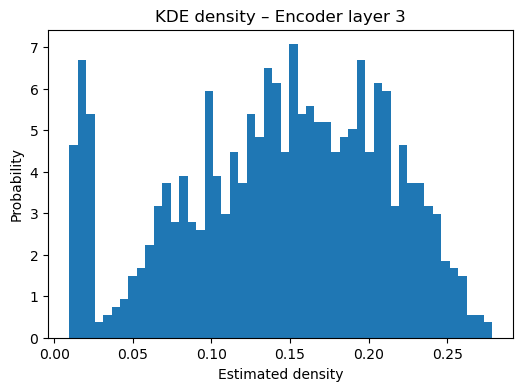

In [95]:
layer_data = RecorderActivat.get("decoder_layer_2")

est = KDEEstimator(sigma=1.0)
est.entropy(layer_data)

density = est.last_density

plt.figure(figsize=(6, 4))
plt.hist(density, bins=50, density=True)
plt.xlabel("Estimated density")
plt.ylabel("Probability")
plt.title("KDE density – Encoder layer 3")
plt.show()

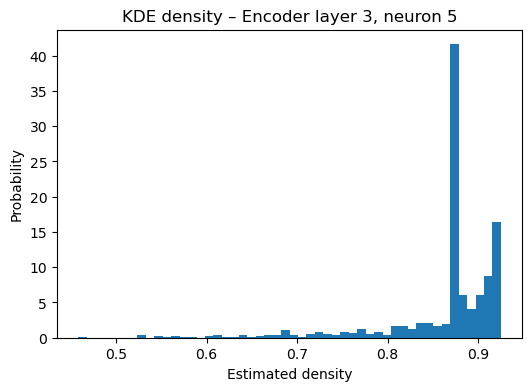

In [96]:
neuron_data = RecorderActivat.get_neuron("encoder_layer_1", neuron_idx=50)

est = KDEEstimator(sigma=1.0)
est.entropy(neuron_data)

density = est.last_density

plt.figure(figsize=(6, 4))
plt.hist(density, bins=50, density=True)
plt.xlabel("Estimated density")
plt.ylabel("Probability")
plt.title("KDE density – Encoder layer 3, neuron 5")
plt.show()

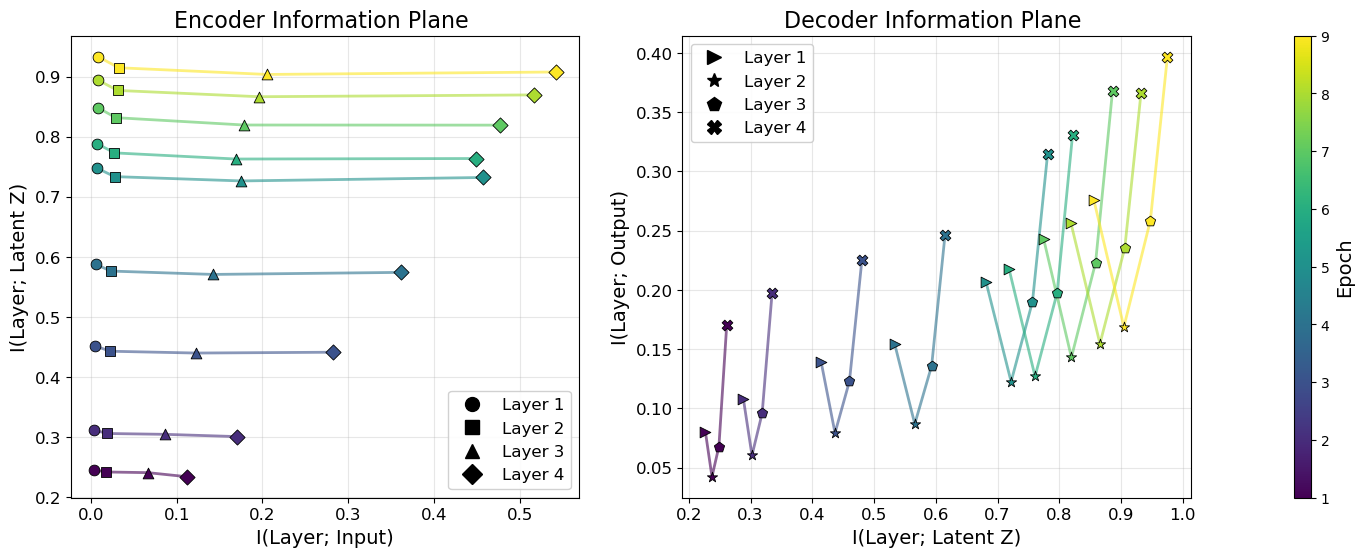

In [97]:
# Variational
PlotInfoPlane(mi_history.encoder, mi_history.decoder, start_epoch=1, end_epoch=13, Step=1)

In [16]:
epochs = 40
final_loss = Training(model, num_epochs=epochs, showImage=False)

Epoch 1/40: 100%|█████████████████████████████| 120/120 [00:04<00:00, 28.76it/s]


TRAIN — Epoch 1/40 — train loss: 0.1014


Epoch 2/40: 100%|█████████████████████████████| 120/120 [00:03<00:00, 32.89it/s]


TRAIN — Epoch 2/40 — train loss: 0.0637


Epoch 3/40: 100%|█████████████████████████████| 120/120 [00:03<00:00, 33.73it/s]


TRAIN — Epoch 3/40 — train loss: 0.0576


Epoch 4/40: 100%|█████████████████████████████| 120/120 [00:03<00:00, 35.62it/s]


TRAIN — Epoch 4/40 — train loss: 0.0512


Epoch 5/40: 100%|█████████████████████████████| 120/120 [00:03<00:00, 36.36it/s]


TRAIN — Epoch 5/40 — train loss: 0.0454


Epoch 6/40: 100%|█████████████████████████████| 120/120 [00:03<00:00, 36.22it/s]


TRAIN — Epoch 6/40 — train loss: 0.0414


Epoch 7/40: 100%|█████████████████████████████| 120/120 [00:03<00:00, 35.07it/s]


TRAIN — Epoch 7/40 — train loss: 0.0386


Epoch 8/40: 100%|█████████████████████████████| 120/120 [00:03<00:00, 38.11it/s]


TRAIN — Epoch 8/40 — train loss: 0.0370


Epoch 9/40: 100%|█████████████████████████████| 120/120 [00:03<00:00, 35.91it/s]


TRAIN — Epoch 9/40 — train loss: 0.0358


Epoch 10/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 35.77it/s]


TRAIN — Epoch 10/40 — train loss: 0.0341


Epoch 11/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.13it/s]


TRAIN — Epoch 11/40 — train loss: 0.0324


Epoch 12/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.13it/s]


TRAIN — Epoch 12/40 — train loss: 0.0309


Epoch 13/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.05it/s]


TRAIN — Epoch 13/40 — train loss: 0.0299


Epoch 14/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.10it/s]


TRAIN — Epoch 14/40 — train loss: 0.0291


Epoch 15/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.30it/s]


TRAIN — Epoch 15/40 — train loss: 0.0284


Epoch 16/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 36.57it/s]


TRAIN — Epoch 16/40 — train loss: 0.0279


Epoch 17/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.42it/s]


TRAIN — Epoch 17/40 — train loss: 0.0273


Epoch 18/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 37.83it/s]


TRAIN — Epoch 18/40 — train loss: 0.0268


Epoch 19/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.09it/s]


TRAIN — Epoch 19/40 — train loss: 0.0261


Epoch 20/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.05it/s]


TRAIN — Epoch 20/40 — train loss: 0.0256


Epoch 21/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.88it/s]


TRAIN — Epoch 21/40 — train loss: 0.0252


Epoch 22/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.33it/s]


TRAIN — Epoch 22/40 — train loss: 0.0248


Epoch 23/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 36.42it/s]


TRAIN — Epoch 23/40 — train loss: 0.0244


Epoch 24/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.37it/s]


TRAIN — Epoch 24/40 — train loss: 0.0241


Epoch 25/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.24it/s]


TRAIN — Epoch 25/40 — train loss: 0.0238


Epoch 26/40: 100%|████████████████████████████| 120/120 [00:02<00:00, 42.68it/s]


TRAIN — Epoch 26/40 — train loss: 0.0234


Epoch 27/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 37.04it/s]


TRAIN — Epoch 27/40 — train loss: 0.0231


Epoch 28/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 39.24it/s]


TRAIN — Epoch 28/40 — train loss: 0.0229


Epoch 29/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 35.93it/s]


TRAIN — Epoch 29/40 — train loss: 0.0225


Epoch 30/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.23it/s]


TRAIN — Epoch 30/40 — train loss: 0.0223


Epoch 31/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.02it/s]


TRAIN — Epoch 31/40 — train loss: 0.0221


Epoch 32/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.06it/s]


TRAIN — Epoch 32/40 — train loss: 0.0218


Epoch 33/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 37.94it/s]


TRAIN — Epoch 33/40 — train loss: 0.0215


Epoch 34/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 37.81it/s]


TRAIN — Epoch 34/40 — train loss: 0.0213


Epoch 35/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 36.38it/s]


TRAIN — Epoch 35/40 — train loss: 0.0211


Epoch 36/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.16it/s]


TRAIN — Epoch 36/40 — train loss: 0.0210


Epoch 37/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 39.11it/s]


TRAIN — Epoch 37/40 — train loss: 0.0208


Epoch 38/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 39.00it/s]


TRAIN — Epoch 38/40 — train loss: 0.0206


Epoch 39/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 37.89it/s]


TRAIN — Epoch 39/40 — train loss: 0.0205


Epoch 40/40: 100%|████████████████████████████| 120/120 [00:03<00:00, 38.15it/s]


TRAIN — Epoch 40/40 — train loss: 0.0203


# 2.bis Debug

In [ ]:
# activations

In [ ]:
# a = activations['decoder_layer_1'].detach().cpu().numpy()[0]
# print(len(a),"\n",a)

In [ ]:
# history_encoder

In [ ]:
# history_decoder

# 3. Results

## VAE outputs

In [17]:
def ShowSomeImages(model, testDataset, device):

    model.eval()
    fig, axs = plt.subplots(5, 2, figsize=(6, 12))

    for i in range(5):
        img, _ = random.choice(testDataset)

        x = img.unsqueeze(0).to(device)

        with torch.no_grad():
            recon, _ = model(x)

        original = img.cpu().squeeze().numpy()
        reconstructed = recon.cpu().squeeze().numpy().reshape(28, 28)

        axs[i, 0].imshow(original, cmap="gist_gray")
        axs[i, 0].set_title("Original")
        axs[i, 0].set_xticks([])
        axs[i, 0].set_yticks([])

        axs[i, 1].imshow(reconstructed, cmap="gist_gray")
        axs[i, 1].set_title("Reconstruction")
        axs[i, 1].set_xticks([])
        axs[i, 1].set_yticks([])

    plt.tight_layout()
    plt.show()

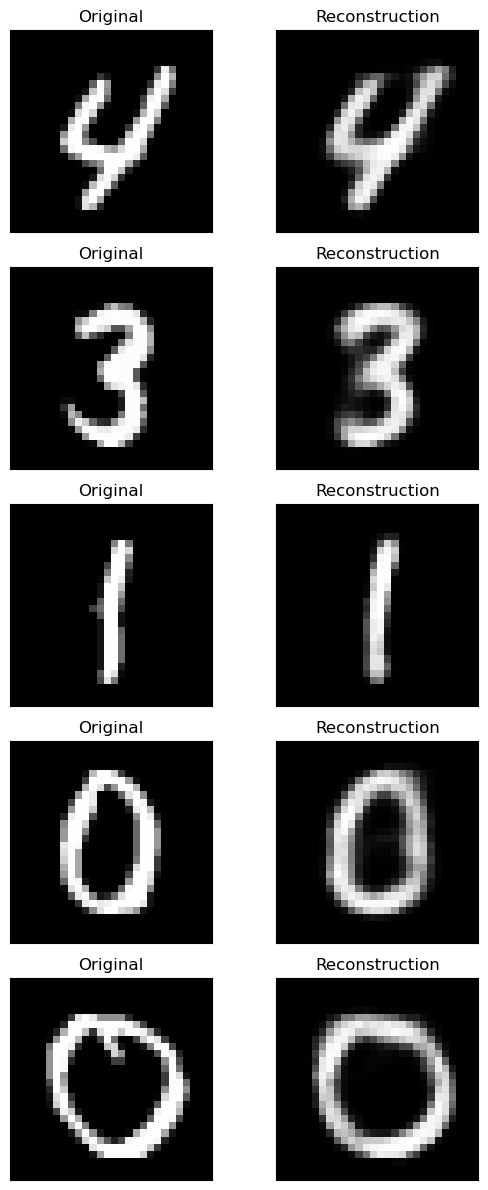

In [18]:
ShowSomeImages(model, testDataset, device)

## VAE loss

In [19]:
def PlotLoss(train_loss_history, val_loss_history):
    epochs = range(1, len(train_loss_history) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_loss_history, color='blue', linewidth=2, label='Training loss')
    plt.plot(epochs, val_loss_history, color='red', linewidth=2, label='Validation loss')

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

ValueError: x and y must have same first dimension, but have shapes (40,) and (0,)

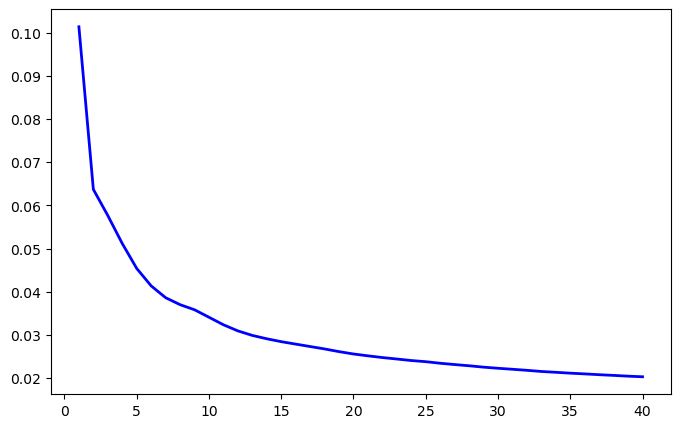

In [20]:
# Variational
PlotLoss(train_loss_history, val_loss_history)

## Mutual Info

In [21]:
def PlotInfoPlane(mi_history_encoder, mi_history_decoder, title_suffix="", 
                  start_epoch=1, end_epoch=-1, Step=5):

    fig = plt.figure(figsize=(16, 6))
    gs = fig.add_gridspec(1, 3, width_ratios=[6, 6, 0.2], wspace=0.3)

    ax_enc = fig.add_subplot(gs[0, 0])
    ax_dec = fig.add_subplot(gs[0, 1])
    ax_cb  = fig.add_subplot(gs[0, 2])

    total_epochs = len(mi_history_encoder)
    if end_epoch == -1 or end_epoch >= total_epochs:
        end_epoch = total_epochs -1

    # NEW: filter epochs by Step
    epoch_range = [ep for ep in range(start_epoch, end_epoch + 1) if ep % Step == 0]
    epochs = len(epoch_range)

    cmap = plt.get_cmap('viridis')
    colors = [cmap(i / max(1, epochs - 1)) for i in range(epochs)]

    encoder_markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', '<', '>']
    decoder_markers = ['>', '*', 'p', 'X', 'H', '>', 'd', 'D', '8', 'o']

    n_layers = len(mi_history_encoder[0])

    # ---------------- ENCODER ----------------
    ax = ax_enc

    for ep_idx, ep in enumerate(epoch_range):
        x = [mi_history_encoder[ep][l][0] for l in range(n_layers)]
        y = [mi_history_encoder[ep][l][1] for l in range(n_layers)]

        ax.plot(x, y, linestyle='-', color=colors[ep_idx],
                alpha=0.6, linewidth=2)

        for l in range(n_layers):
            marker = encoder_markers[l % len(encoder_markers)]
            ax.scatter(x[l], y[l],
                       facecolors=[colors[ep_idx]],
                       edgecolors='black',
                       s=60, marker=marker,
                       linewidths=0.6, zorder=3)

    ax.set_xlabel("I(Layer; Input)", fontsize=14)
    ax.set_ylabel("I(Layer; Latent Z)", fontsize=14)
    ax.set_title(f"Encoder Information Plane {title_suffix}", fontsize=16)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', labelsize=12)

    enc_handles = []
    enc_labels = []
    for l in range(n_layers):
        mk = encoder_markers[l % len(encoder_markers)]
        handle = Line2D([0], [0], marker=mk, color='black',
                        markerfacecolor='black',
                        markeredgecolor='black',
                        markersize=10, linestyle='None')
        enc_handles.append(handle)
        enc_labels.append(f'Layer {l+1}')

    ax_enc.legend(enc_handles, enc_labels, framealpha=0.9, fontsize=12, title_fontsize=13)

    # ---------------- DECODER ----------------
    ax = ax_dec

    for ep_idx, ep in enumerate(epoch_range):
        x = [mi_history_decoder[ep][l][0] for l in range(n_layers)]
        y = [mi_history_decoder[ep][l][1] for l in range(n_layers)]

        ax.plot(x, y, linestyle='-', color=colors[ep_idx],
                alpha=0.6, linewidth=2)

        for l in range(n_layers):
            marker = decoder_markers[l % len(decoder_markers)]
            ax.scatter(x[l], y[l],
                       facecolors=[colors[ep_idx]],
                       edgecolors='black',
                       s=60, marker=marker,
                       linewidths=0.6, zorder=3)

    ax.set_xlabel("I(Layer; Latent Z)", fontsize=14)
    ax.set_ylabel("I(Layer; Output)", fontsize=14)
    ax.set_title(f"Decoder Information Plane {title_suffix}", fontsize=16)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', labelsize=12)

    dec_handles = []
    dec_labels = []
    for l in range(n_layers):
        mk = decoder_markers[l % len(decoder_markers)]
        handle = Line2D([0], [0], marker=mk, color='black',
                        markerfacecolor='black',
                        markeredgecolor='black',
                        markersize=10, linestyle='None')
        dec_handles.append(handle)
        dec_labels.append(f'Layer {l+1}')

    ax_dec.legend(dec_handles, dec_labels, framealpha=0.9, fontsize=12, title_fontsize=13)

    # ---------------- COLORBAR ----------------
    norm = Normalize(vmin=start_epoch, vmax=end_epoch)
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar = fig.colorbar(sm, cax=ax_cb, orientation='vertical')
    cbar.set_ticks(epoch_range)
    cbar.set_ticklabels(epoch_range)
    cbar.set_label("Epoch", fontsize=14)

    plt.show()

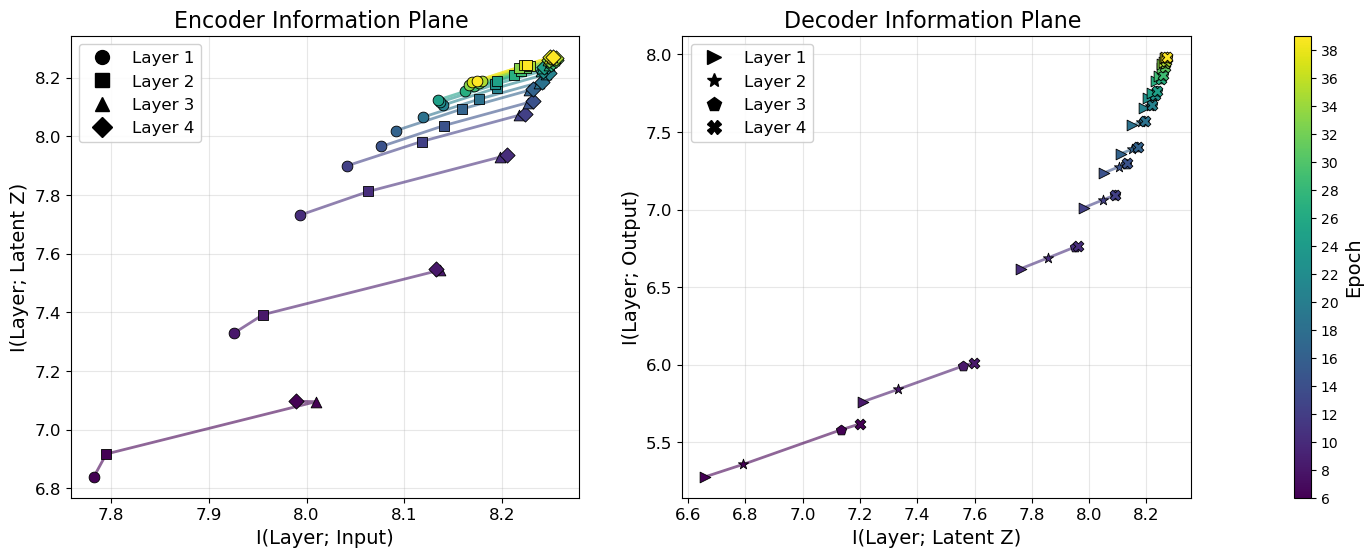

In [23]:
# Variational
PlotInfoPlane(history_encoder, history_decoder, start_epoch=6, end_epoch=40, Step=2)

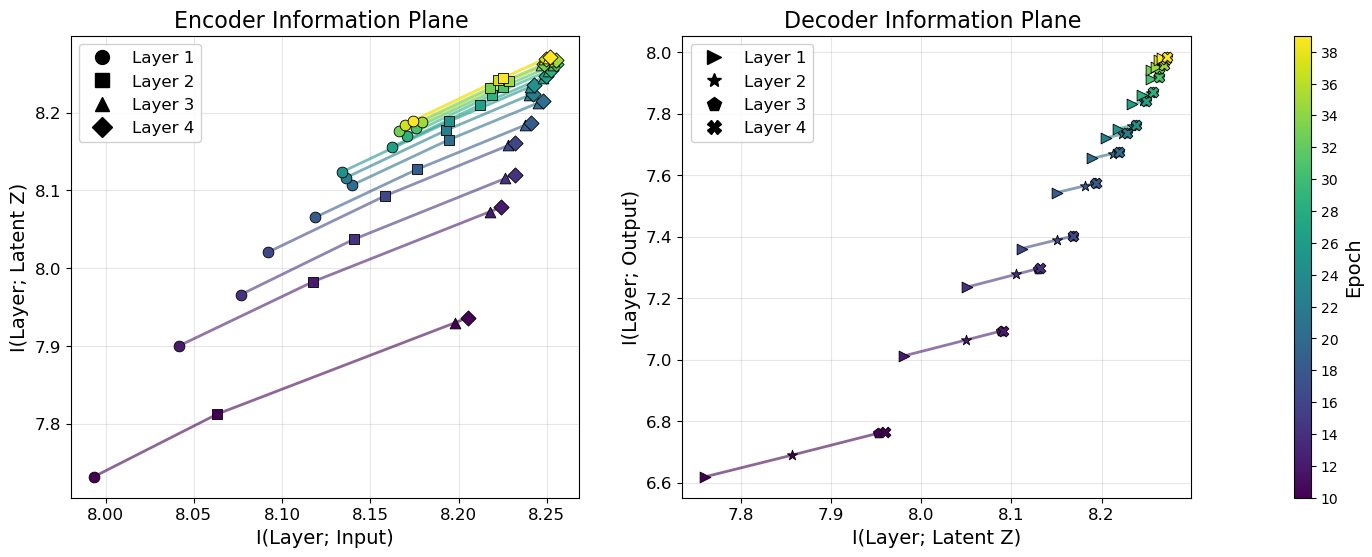

In [30]:
# Variational
PlotInfoPlane(history_encoder, history_decoder, start_epoch=10, end_epoch=40, Step=2)

In [24]:
def PlotInfoPlaneLayers(mi_history_encoder, mi_history_decoder,
                            title_suffix="",
                            start_epoch=1, end_epoch=-1, Step=1):
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    # --- Select epochs based on user settings ---
    total_epochs = len(mi_history_encoder)
    if end_epoch == -1 or end_epoch >= total_epochs:
        end_epoch = total_epochs - 1

    # Filter epochs: start → end, stepping by Step
    epoch_range = [ep for ep in range(start_epoch, end_epoch + 1) if (ep - start_epoch) % Step == 0]

    # --- Figure layout ---
    fig = plt.figure(figsize=(16, 6))
    gs = fig.add_gridspec(1, 2, width_ratios=[6, 6], wspace=0.3)

    ax_enc = fig.add_subplot(gs[0, 0])
    ax_dec = fig.add_subplot(gs[0, 1])

    n_layers = len(mi_history_encoder[0])

    # ----- Color scales -----
    encoder_colors = [plt.cm.Reds((i+1)/n_layers) for i in range(n_layers)]
    decoder_colors = [plt.cm.Blues((i+1)/n_layers) for i in range(n_layers)]

    # marker shapes
    markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', '<', '>']

    # ---------------- ENCODER ----------------
    for l in range(n_layers):
        x = [mi_history_encoder[ep][l][0] for ep in epoch_range]
        y = [mi_history_encoder[ep][l][1] for ep in epoch_range]

        ax_enc.scatter(
            x, y,
            s=60,
            marker=markers[l % len(markers)],
            facecolors=encoder_colors[l],
            edgecolors='black',
            linewidths=0.6
        )

    ax_enc.set_xlabel("I(Layer; Input)", fontsize=14)
    ax_enc.set_ylabel("I(Layer; Latent Z)", fontsize=14)
    ax_enc.set_title(f"Encoder Information Plane {title_suffix}", fontsize=16)
    ax_enc.grid(True, alpha=0.3)
    ax_enc.tick_params(axis='both', labelsize=12)

    # Encoder legend
    enc_handles = [
        Line2D([0], [0],
               marker=markers[l % len(markers)],
               color='black',
               markerfacecolor=encoder_colors[l],
               markeredgecolor='black',
               markersize=10,
               linestyle='None')
        for l in range(n_layers)
    ]
    ax_enc.legend(enc_handles, [f"Layer {l+1}" for l in range(n_layers)],
                  framealpha=0.9, fontsize=12, title_fontsize=13)

    # ---------------- DECODER ----------------
    for l in range(n_layers):
        x = [mi_history_decoder[ep][l][0] for ep in epoch_range]
        y = [mi_history_decoder[ep][l][1] for ep in epoch_range]

        ax_dec.scatter(
            x, y,
            s=60,
            marker=markers[l % len(markers)],
            facecolors=decoder_colors[l],
            edgecolors='black',
            linewidths=0.6
        )

    ax_dec.set_xlabel("I(Layer; Latent Z)", fontsize=14)
    ax_dec.set_ylabel("I(Layer; Output)", fontsize=14)
    ax_dec.set_title(f"Decoder Information Plane {title_suffix}", fontsize=16)
    ax_dec.grid(True, alpha=0.3)
    ax_dec.tick_params(axis='both', labelsize=12)

    # Decoder legend
    dec_handles = [
        Line2D([0], [0],
               marker=markers[l % len(markers)],
               color='black',
               markerfacecolor=decoder_colors[l],
               markeredgecolor='black',
               markersize=10,
               linestyle='None')
        for l in range(n_layers)
    ]
    ax_dec.legend(dec_handles, [f"Layer {l+1}" for l in range(n_layers)],
                  framealpha=0.9, fontsize=12, title_fontsize=13)

    plt.show()

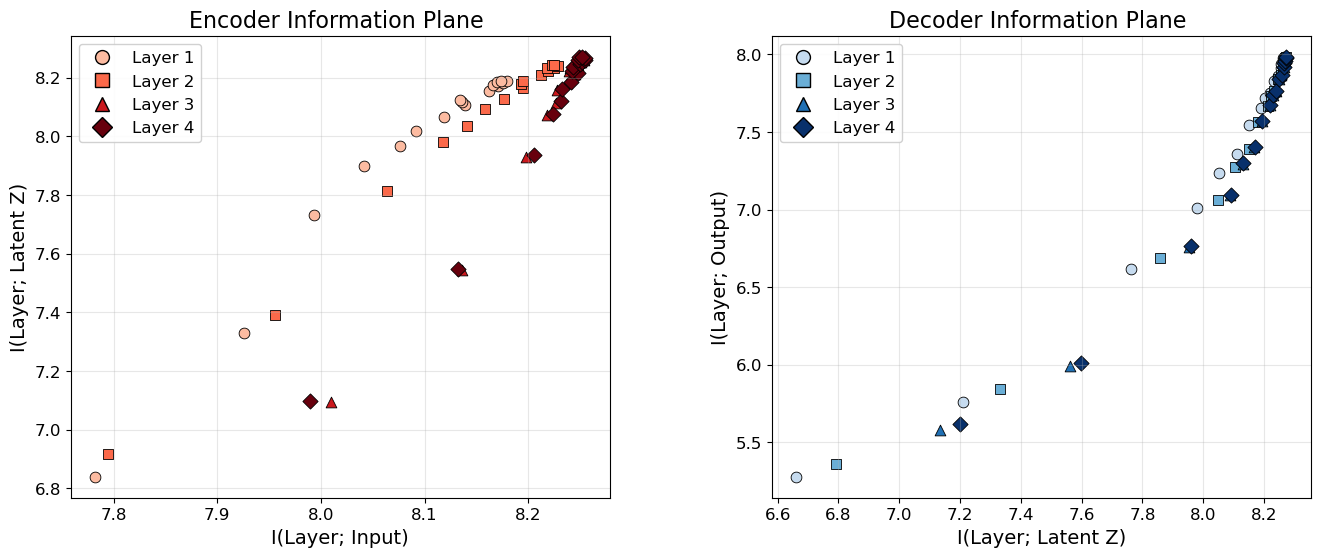

In [25]:
# No variation 80 epoch
PlotInfoPlaneLayers(history_encoder, history_decoder, start_epoch=6, end_epoch=40, Step=2)

In [28]:
def PlotInputLatentOutput(mi_input_latent, mi_latent_output, title_suffix="", start_epoch=1, end_epoch=-1, Step=5):

    # --- Determine epoch range ---
    total_epochs = len(mi_input_latent)
    if end_epoch == -1 or end_epoch >= total_epochs:
        end_epoch = total_epochs - 1

    epoch_range = [ep for ep in range(start_epoch, end_epoch + 1)
                   if ep % Step == 0]

    # --- Extract MI values for selected epochs ---
    X_vals = [mi_input_latent[ep] for ep in epoch_range]
    Y_vals = [mi_latent_output[ep] for ep in epoch_range]

    cmap = plt.get_cmap("Greens")
    colors = [cmap(i / max(1, len(epoch_range) - 1)) for i in range(len(epoch_range))]

    fig, ax = plt.subplots(figsize=(7, 6))

    for i, ep in enumerate(epoch_range):
        ax.scatter(
            X_vals[i], Y_vals[i],
            s=80,
            marker='o',
            facecolors=colors[i],
            edgecolors='black',
            linewidths=0.6,
            label=f"Epoch {ep}"
        )

    # Labels and title
    ax.set_xlabel("MI(Input; Latent)", fontsize=14)
    ax.set_ylabel("MI(Latent; Output)", fontsize=14)
    ax.set_title(f"Global Mutual Information {title_suffix}", fontsize=16)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', labelsize=12)

    # --- Colorbar ---
    norm = Normalize(vmin=start_epoch, vmax=end_epoch)
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("Epoch", fontsize=14)
    cbar.set_ticks(epoch_range)
    cbar.set_ticklabels(epoch_range)

    plt.tight_layout()
    plt.show()

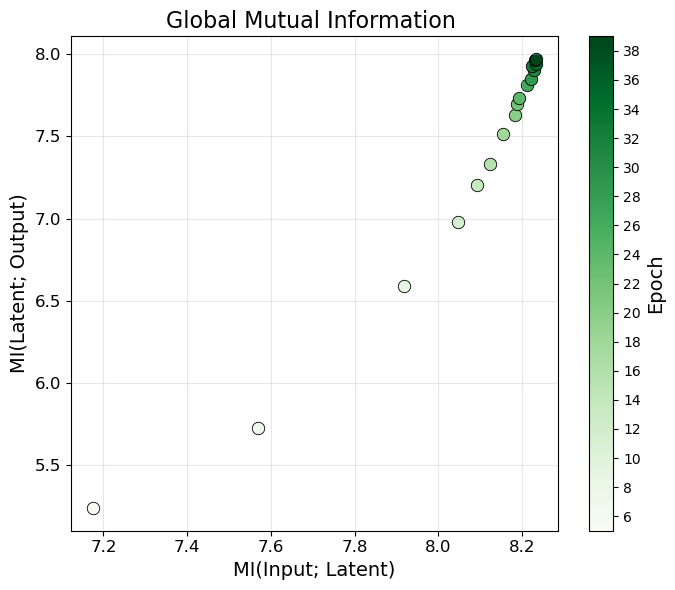

In [29]:
# Variation 40 epoch
PlotInputLatentOutput(history_input_latent, history_latent_output, start_epoch=5, end_epoch=40, Step=2)